In [6]:
'''
Author:        James Parkington
Created Date:  7/29/2023
Modified Date: 7/29/2023

Any imports that are shared across cells can be imported through this initial cell. I've also introduced some 
runtime configuration parameters to define attributes of each chart once, so that they're treated as defaults 
for each subsequent plot.
'''

import calendar            as cal
import numpy               as np
import pandas              as pd
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.patches  as pch

from adjustText        import adjust_text
from cycler            import cycler
from datetime          import datetime     as dtt
from scipy.interpolate import interp1d     as ip
from scipy.optimize    import minimize     as mn
from scipy.stats       import gaussian_kde as gk
from typing            import *

cividis = plt.cm.cividis
colors  = [cividis(i) for i in [0.8, 0.15]] + [plt.cm.viridis(i) for i in [0.8, 0.15]] 
plot_params = {
    # Axes parameters                            # Tick parameters
    'axes.facecolor'     : 'black',              'xtick.labelsize'    : 8,
    'axes.grid'          : False,                'xtick.color'        : 'white',
    'axes.labelcolor'    : 'white',              'xtick.major.size'   : 0,
    'axes.spines.left'   : False,                'ytick.labelsize'    : 8,
    'axes.spines.right'  : False,                'ytick.color'        : 'white',
    'axes.spines.top'    : False,                'ytick.major.size'   : 0,
    'axes.labelsize'     : 10,
    'axes.labelweight'   : 'bold',               # Figure parameters
    'axes.titlesize'     : 12,                   'figure.facecolor'   : 'black',
    'axes.titleweight'   : 'bold',               'figure.figsize'     : (15, 10), 
    'axes.labelpad'      : 15,                   'figure.autolayout'  : True,    

    # Grid parameters                            
    'grid.linestyle'     : ':',                  
    'grid.color'         : '0.5',                

    # Font and text parameters                   # Legend parameters 
    'font.family'        : 'DejaVu Sans Mono',   'legend.facecolor'   : '0.3',
    'font.size'          : 8,                    'legend.edgecolor'   : '0.3',
    'font.style'         : 'normal',             'legend.borderpad'   : 0.75, 
    'text.color'         : 'white',              'legend.framealpha'  : '0.5',
    'axes.prop_cycle'    : cycler(color = colors)}

plt.rcParams.update(plot_params)

In [7]:
def load_bike_sharing_data() -> pd.DataFrame:   
    '''
    Loads the Bike Sharing Dataset from the UCI Machine Learning Repository.

    The dataset represents two years (2011 and 2012) of the hourly count of rental bikes from the Capital 
    Bikeshare system in Washington D.C., USA. The counts are categorized as casual, registered, or total, with 
    additional information about the specific hour, weather conditions, and more.

    The dataset beings with the following fields:
    - instant     (int)   : Record index
    - dteday      (str)   : Date
    - season      (int)   : Season (1: spring, 2: summer, 3: autumn, 4: winter)
    - yr          (int)   : Year (0: 2011, 1: 2012)
    - mnth        (int)   : Month (1 to 12)
    - hr          (int)   : Hour (0 to 23)
    - holiday     (int)   : Whether the day is a holiday or not
    - weekday     (int)   : Day of the week
    - workingday  (int)   : 1 if the day is neither a weekend nor holiday, otherwise 0
    - weathersit  (int)   : Weather conditions (1: clear, 2: mist/cloudy, 3: light snow/rain, 4: heavy rain/snow/fog)
    - temp        (float) : Normalized temperature in Celsius (values divided by 41)
    - atemp       (float) : Normalized feeling temperature in Celsius (values divided by 50)
    - hum         (float) : Normalized humidity (values divided by 100)
    - windspeed   (float) : Normalized wind speed (values divided by 67)
    - casual      (int)   : Count of casual users
    - registered  (int)   : Count of registered users
    - cnt         (int)   : Count of total rental bikes including both casual and registered

    These fields are added immediately following to avoid repeating transformations:
    - ordinal     (int)   : Ordinal representation of the date

    After loading the dataset, we'll conduct an exploratory data analysis to uncover the underlying patterns 
    and relationships in the data. This will include a variety of techniques such as data visualization, 
    aggregation, and correlation analysis.

    Note: I learned while carrying out the exercise that the included `season` column is misleading and not
          useful in the context of the other datetime fields. For example, it considers Jan, Feb, and Mar to be
          "Spring", which is innacurate, so I've curated a new `season` field with the helper function `get_season()`.

          Also, all 1/0 (int) fields above are converted to booleans.

    Returns:
        pd.DataFrame: The Bike Sharing dataset as a pandas DataFrame.
    '''

    def get_season(date: pd.Timestamp) -> int:
        '''
        Seasons are defined as:
            Spring: from March 21 to June 20
            Summer: from June 21 to September 22
            Autumn: from September 23 to December 20
            Winter: from December 21 to March 20

        Parameters:
            date (datetime) : Timestamp object

        Returns:
            int : season of the date (1: Spring, 2: Summer, 3: Autumn, 4: Winter)
        '''

        day_of_year = date.timetuple().tm_yday

        if   day_of_year in range(80,  172): return 1  # Spring
        elif day_of_year in range(172, 265): return 2  # Summer
        elif day_of_year in range(265, 355): return 3  # Autumn
        else:                                return 4  # Winter

    df = pd.read_csv("./Data/hour.csv")
    df['dteday']     = pd.to_datetime(df['dteday'])
    df['season']     = df['dteday'].apply(get_season)
    df['holiday']    = df['holiday'].astype(bool)
    df['workingday'] = df['workingday'].astype(bool)
    df['ordinal']    = df['dteday'].apply(lambda x: x.toordinal())

    return df

bike_sharing = load_bike_sharing_data()
bike_sharing

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,ordinal
0,1,2011-01-01,4,0,1,0,False,6,False,1,0.24,0.2879,0.81,0.0000,3,13,16,734138
1,2,2011-01-01,4,0,1,1,False,6,False,1,0.22,0.2727,0.80,0.0000,8,32,40,734138
2,3,2011-01-01,4,0,1,2,False,6,False,1,0.22,0.2727,0.80,0.0000,5,27,32,734138
3,4,2011-01-01,4,0,1,3,False,6,False,1,0.24,0.2879,0.75,0.0000,3,10,13,734138
4,5,2011-01-01,4,0,1,4,False,6,False,1,0.24,0.2879,0.75,0.0000,0,1,1,734138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,4,1,12,19,False,1,True,2,0.26,0.2576,0.60,0.1642,11,108,119,734868
17375,17376,2012-12-31,4,1,12,20,False,1,True,2,0.26,0.2576,0.60,0.1642,8,81,89,734868
17376,17377,2012-12-31,4,1,12,21,False,1,True,1,0.26,0.2576,0.60,0.1642,7,83,90,734868
17377,17378,2012-12-31,4,1,12,22,False,1,True,1,0.26,0.2727,0.56,0.1343,13,48,61,734868


Question: How can we preprocess our data to make it suitable for predictions?
    Section: Data Preprocessing
        Data Cleaning
        Feature Engineering
        Data Normalization
        One-Hot Encoding

"""
**Question:** How can we preprocess our data to make it suitable for predictions?

**Methodology:**
- **Data Cleaning:** Ensure there are no missing or outlier values that can distort predictions.
- **Feature Engineering:** Extract and create relevant features that can enhance the predictive power of the model.
- **Data Normalization:** Normalize features to bring them to a similar scale.
- **One-Hot Encoding:** Convert categorical variables into a format that can be provided to machine learning algorithms to improve predictions.

**Mathematical Concepts:**
For data normalization, the formula used is:
\[ x' = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)} \]
where \( x' \) is the normalized value and \( x \) is the original value.
"""

Question: How can we predict the target variable using the features?
    Section: Multivariate Linear Regression
        Mathematical Explanation
        Cost Function Definition
        Gradient and Hessian Calculation

""
**Question:** How can we predict the target variable using the features?

**Methodology:**
- **Mathematical Explanation:** Multivariate linear regression is an extension of simple linear regression to predict the target variable using multiple features.
- **Cost Function Definition:** Define the cost function that measures the prediction error of the model.
- **Gradient and Hessian Calculation:** Calculate the first and second derivatives of the cost function to be used in optimization.

**Mathematical Concepts:**
The hypothesis for multivariate linear regression is given by:
\[ h(\theta) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n \]
The cost function (Mean Squared Error) is:
\[ J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (h(\theta)^{(i)} - y^{(i)})^2 \]
where \( m \) is the number of training examples.
"""

Question: How can we optimize our regression model's parameters to minimize prediction errors?
    Section: Newton's Method Optimization
        Mathematical Explanation of Newton's Method
        Implementation and Parameter Optimization

"""
**Question:** How can we optimize our regression model's parameters to minimize prediction errors?

**Methodology:**
- **Mathematical Explanation:** Newton's Method is an iterative optimization algorithm used to find the minimum of a function.
- **Implementation:** Use the Newton's Method to optimize the model parameters.
- **Parameter Optimization:** Adjust the model parameters to minimize the cost function.

**Mathematical Concepts:**
Newton's Method updates the parameters using the following formula:
\[ \theta := \theta - \text{Hessian}^{-1} \times \text{Gradient} \]
where the Hessian is the matrix of the second derivatives of the cost function and the Gradient is the vector of the first derivatives.
"""

Question: How has the growth in bike rentals evolved over time, and how can we incorporate this information into our predictions?
    Section: Velocity Regression Analysis
        Mathematical Explanation of Velocity and Acceleration
        Linear Regression on Velocity Ratio
        Slope Interpretation and Prediction Adjustment

"""
**Question:** How has the growth in bike rentals evolved over time, and how can we incorporate this information into our predictions?

**Methodology:**
- **Mathematical Explanation:** Understand the concept of velocity and acceleration in the context of growth in bike rentals.
- **Linear Regression:** Apply linear regression on the velocity ratio to understand the growth trend.
- **Slope Interpretation:** Interpret the slope of the regression to adjust the predictions.

**Mathematical Concepts:**
Velocity represents the rate of change of a quantity, and acceleration represents the rate of change of velocity. In this context:
- **Velocity:** Month-to-month growth in cumulative counts.
- **Acceleration:** Change in velocity from month to month.
The linear regression line for any metric \( m \) is given by:
\[ y(t) = m \times t + b \]
where \( m \) is the slope and \( b \) is the y-intercept.
"""

Question: How do our predictions for the synthetic January 2013 compare with the historical data, and how can we visualize this comparison?
    Section: Visualization and Analysis of Predictions
        Plotting Original and Adjusted Predictions
        Interpretation and Conclusion

"""
**Question:** How do our predictions for the synthetic January 2013 compare with the historical data, and how can we visualize this comparison?

**Methodology:**
- **Plotting:** Visualize the original and adjusted predictions for January 2013.
- **Interpretation:** Understand the significance of the predictions in the context of historical data.
- **Conclusion:** Draw insights from the visualizations.

**Mathematical Concepts:**
Visualization provides an intuitive understanding of the data. By comparing the original and adjusted predictions, we can gauge the accuracy and reliability of the predictions.
"""

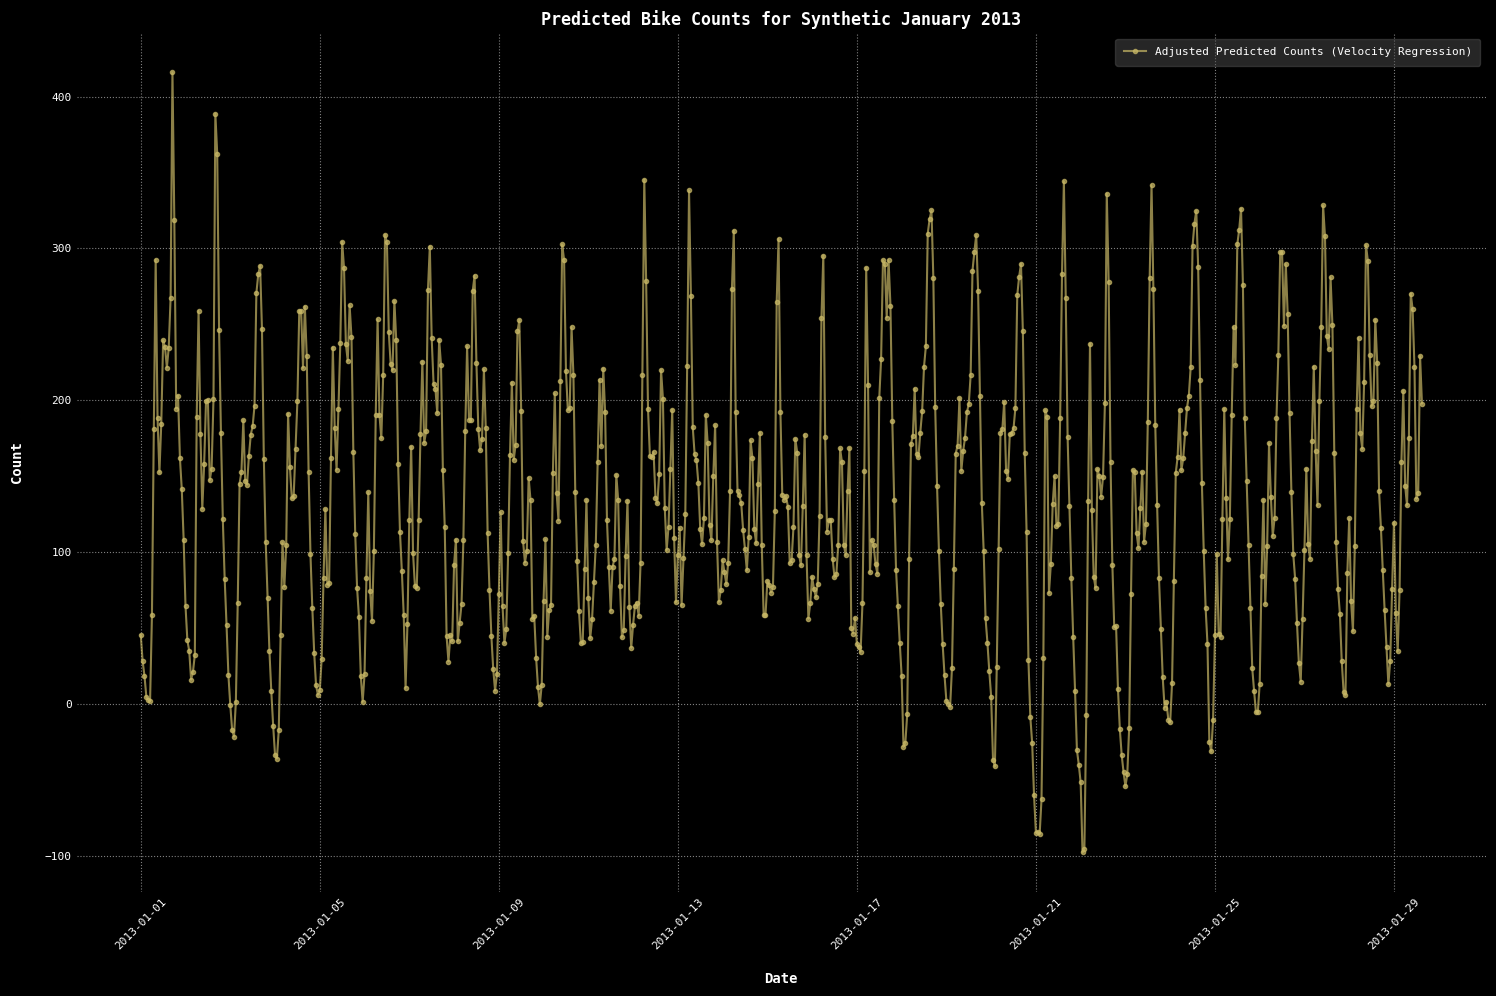

In [18]:
def predict_december_2012_v7(df):
    df = df.copy()  # Create a copy to avoid modifying the original dataframe
    
    # 1. Feature Engineering

    # Normalize continuous columns
    def normalize(column):
        min_val = column.min()
        max_val = column.max()
        return (column - min_val) / (max_val - min_val)

    df['temp'] = normalize(df['temp'])

    # Split data into train and test sets
    train = df[df["dteday"] < "2012-12-01"].sample(frac=0.5, random_state=42)  # Using 50% of the data for quicker optimization

    # Redefine the one-hot encoding function without dropping the original column
    def one_hot_encode_v2(df, column_name):
        for value in df[column_name].unique():
            df[f"{column_name}_{value}"] = (df[column_name] == value).astype(int)

    # One-Hot Encoding for the subset of categorical variables for the entire dataset
    for col in ['hr', 'weekday', 'weathersit']:
        one_hot_encode_v2(df, col)

    # Sample the data again
    train_subset = df[df["dteday"] < "2012-12-01"].sample(frac=0.5, random_state=42)

    # Feature extraction for the training data
    selected_cols_subset = ['temp'] + [col for col in df.columns if col.startswith(('hr_', 'weekday_', 'weathersit_'))]

    # Ensure that the sampled data has the same columns as the full dataset
    for col in selected_cols_subset:
        if col not in train_subset:
            train_subset[col] = 0

    # Ridge Regression Objective, Gradient, and Hessian functions

    def ridge_regression_objective(params, features, target, alpha=0.01):
        """
        Compute the objective value for Ridge Regression (L2 regularization).
        """
        predictions = np.dot(features, params)
        mse = np.mean((predictions - target) ** 2)
        regularization = alpha * np.sum(params ** 2)
        return mse + regularization

    def ridge_regression_gradient(params, features, target, alpha=0.01):
        """
        Compute the gradient of the objective function for Ridge Regression.
        """
        n = len(target)
        predictions = np.dot(features, params)
        gradient_mse = (2/n) * np.dot(features.T, (predictions - target))
        gradient_regularization = 2 * alpha * params
        return gradient_mse + gradient_regularization

    def ridge_regression_hessian(params, features, alpha=0.01):
        """
        Compute the Hessian of the objective function for Ridge Regression.
        """
        n = len(features)
        hessian_mse = (2/n) * np.dot(features.T, features)
        hessian_regularization = 2 * alpha * np.eye(features.shape[1])
        return hessian_mse + hessian_regularization

    # Extract features and target from the sampled data
    X_train_subset = train_subset[selected_cols_subset].values
    y_train_subset = train_subset['cnt'].values

    def newtons_method(features, target, alpha=0.01, max_iters=1000, tol=1e-6):
        """
        Newton's method optimization for Ridge Regression.
        """
        # Initialize parameters
        params = np.zeros(features.shape[1])
        previous_loss = float('inf')
        
        # For storing history (for potential debugging and convergence plots)
        loss_history = []

        for i in range(max_iters):
            # Compute current loss
            current_loss = ridge_regression_objective(params, features, target, alpha)
            loss_history.append(current_loss)
            
            # Compute the gradient and Hessian
            gradient = ridge_regression_gradient(params, features, target, alpha)
            hessian = ridge_regression_hessian(params, features, alpha)
            
            # Update parameters using Newton's method
            params = params - np.dot(np.linalg.inv(hessian), gradient)
            
            # Check for convergence
            if abs(previous_loss - current_loss) < tol:
                break
                
            previous_loss = current_loss

        return params, loss_history

    # Run the Newton's method optimizer
    optimized_params_newton, loss_history_newton = newtons_method(X_train_subset, y_train_subset)

    # Extract data for January 2011 and January 2012
    january_2011 = df[df["dteday"].between("2011-01-01", "2011-01-31")]
    january_2012 = df[df["dteday"].between("2012-01-01", "2012-01-31")]

    # Calculate the average of the feature values for corresponding hours and days for January 2011 and 2012
    averaged_features = (january_2011[selected_cols_subset].reset_index(drop=True) + 
                        january_2012[selected_cols_subset].reset_index(drop=True)) / 2

    # Predict counts for the synthetic January 2013 using the optimized parameters from Newton's method
    predictions_january_2013 = np.dot(averaged_features, optimized_params_newton)

    # Extract the dates for January 2013 for visualization
    january_2013_dates = pd.date_range(start="2013-01-01", end="2013-01-31", freq='H')[:-1]  # excluding the last hour
    
    # Remove NaN values from predictions and the corresponding dates
    valid_predictions = predictions_january_2013[~np.isnan(predictions_january_2013)]
    valid_dates = january_2013_dates[:len(valid_predictions)]

    # Recreate the grouped data by month from the bike_sharing dataframe
    g = df.groupby(['yr', 'mnth'])['cnt'].sum().reset_index()
    g['cumulative'] = g['cnt'].cumsum()
    g['velocity'] = np.gradient(g['cumulative'])
    r = g['velocity'] / g['velocity'].iloc[0]

    # Calculate the slope of the velocity regression
    m_slope, b_intercept = np.polyfit(g.index, r, 1)

    # Adjust the January 2013 predictions using the predicted growth rate based on the slope
    adjusted_predictions_v3_january_2013 = valid_predictions * (1 + m_slope)

    return valid_dates, valid_predictions, adjusted_predictions_v3_january_2013

# Extract the predictions
valid_dates, valid_predictions, adjusted_predictions_v3_january_2013 = predict_december_2012_v7(bike_sharing)

# Adjusted Predicted counts for January 2013
plt.plot(valid_dates, adjusted_predictions_v3_january_2013, 
         label="Adjusted Predicted Counts (Velocity Regression)", marker='.', linestyle='-', alpha=0.7)

plt.title("Predicted Bike Counts for Synthetic January 2013")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()
